# Conv2D를 활용한 흑백 이미지 컬러 복원 [2조 임재원]
---

In [126]:
# 모듈 로딩
import cv2, os, glob, platform, warnings
import numpy as np
import matplotlib.pyplot as plt
from Subpixel import Subpixel
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Input, Activation, Dense, Flatten, UpSampling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

warnings.filterwarnings('ignore')

# [1] 데이터 로딩 및 확인

### [1-1] 흑백 이미지 로딩

In [80]:
# 이미지 담을 리스트, 파일 경로 생성
hr_image = []
PATH_HR = r'./data/HR/'

# 폴더 내 모든 이미지 읽고 저장
for filename in os.listdir(PATH_HR):
    img = cv2.imread(PATH_HR + filename).reshape(384, 384, 3)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hr_image.append(img)

# numpy 배열 형태로 저장
hr_image = np.array(hr_image)
hr_image.shape

(100, 384, 384, 3)

### [1-2] 컬러 이미지 로딩

In [81]:
# 이미지 담을 리스트, 파일 경로 생성
lr_image = []
PATH_LR = r'./data/LR/'

# 폴더 내 모든 이미지 읽고 저장
for filename in os.listdir(PATH_LR):
    img = cv2.imread(PATH_LR + filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(384, 384), interpolation=cv2.INTER_LINEAR)
    lr_image.append(img)

# numpy 배열 형태로 저장
lr_image = np.array(lr_image)
lr_image.shape

(100, 384, 384, 3)

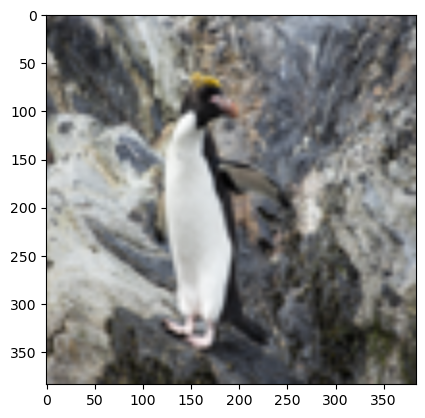

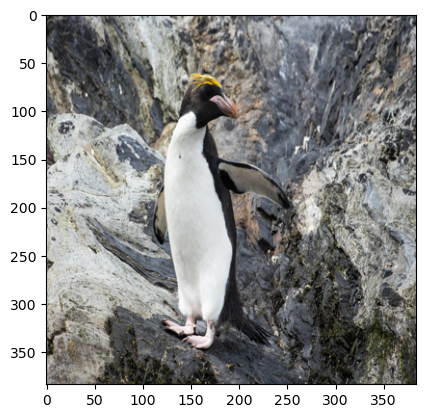

In [82]:
plt.imshow(lr_image[0])
plt.show()
plt.imshow(hr_image[0])
plt.show()

### [1-3] 이미지 확인

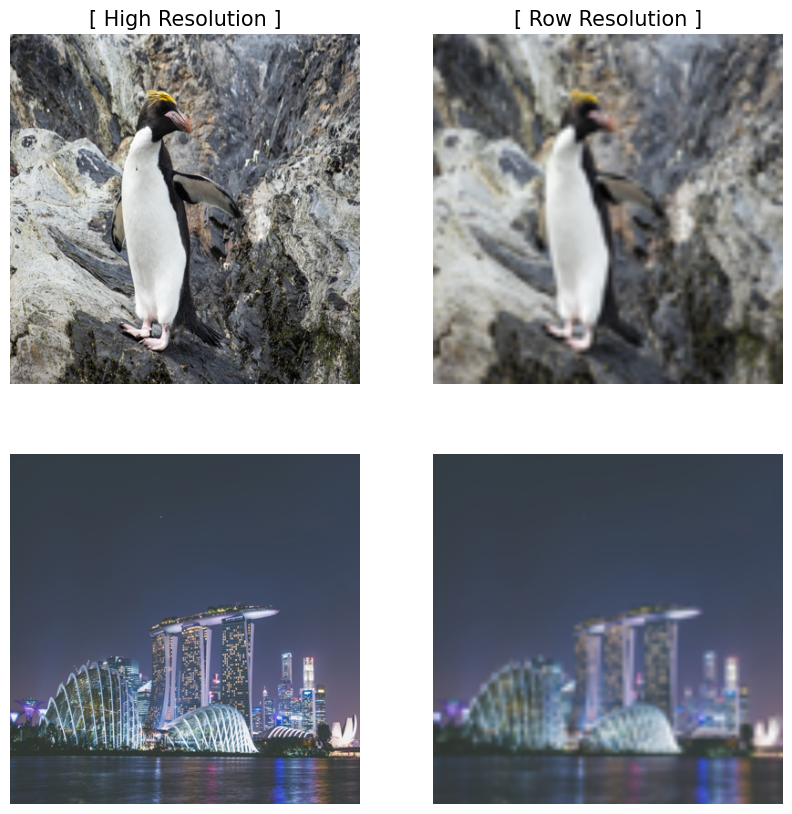

In [83]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].set_title('[ High Resolution ]', size=15)
axes[0, 0].imshow(hr_image[0])
axes[0, 0].axis('off')
axes[0, 1].set_title('[ Row Resolution ]', size=15)
axes[0, 1].imshow(lr_image[0])
axes[0, 1].axis('off')
axes[1, 0].imshow(hr_image[5])
axes[1, 0].axis('off')
axes[1, 1].imshow(lr_image[5])
axes[1, 1].axis('off')
plt.show()

# [2] 데이터 전처리

### [2-1] 픽셀값 0~1사이로 정규화

In [84]:
hr_image = hr_image / 255.0
lr_image = lr_image / 255.0

### [2-2] 트레인/테스트 데이터 분리

In [85]:
x_train, x_test, y_train, y_test = train_test_split(lr_image, hr_image,
                                                    test_size=0.1,
                                                    random_state=42)

# [3] 모델 구상

In [86]:
x_train.shape, y_train.shape

((90, 384, 384, 3), (90, 384, 384, 3))

In [103]:
# model = Sequential()

In [112]:
# model.add(Input(shape=(384, 384, 3)))
# model.add(Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(Conv2D(3, kernel_size=3, activation='sigmoid', padding='same'))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_18 (Sequential)     (None, 192, 192, 12  3584        ['input_5[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_19 (Sequential)     (None, 96, 96, 128)  147584      ['sequential_18[0][0]']          
                                                                                            

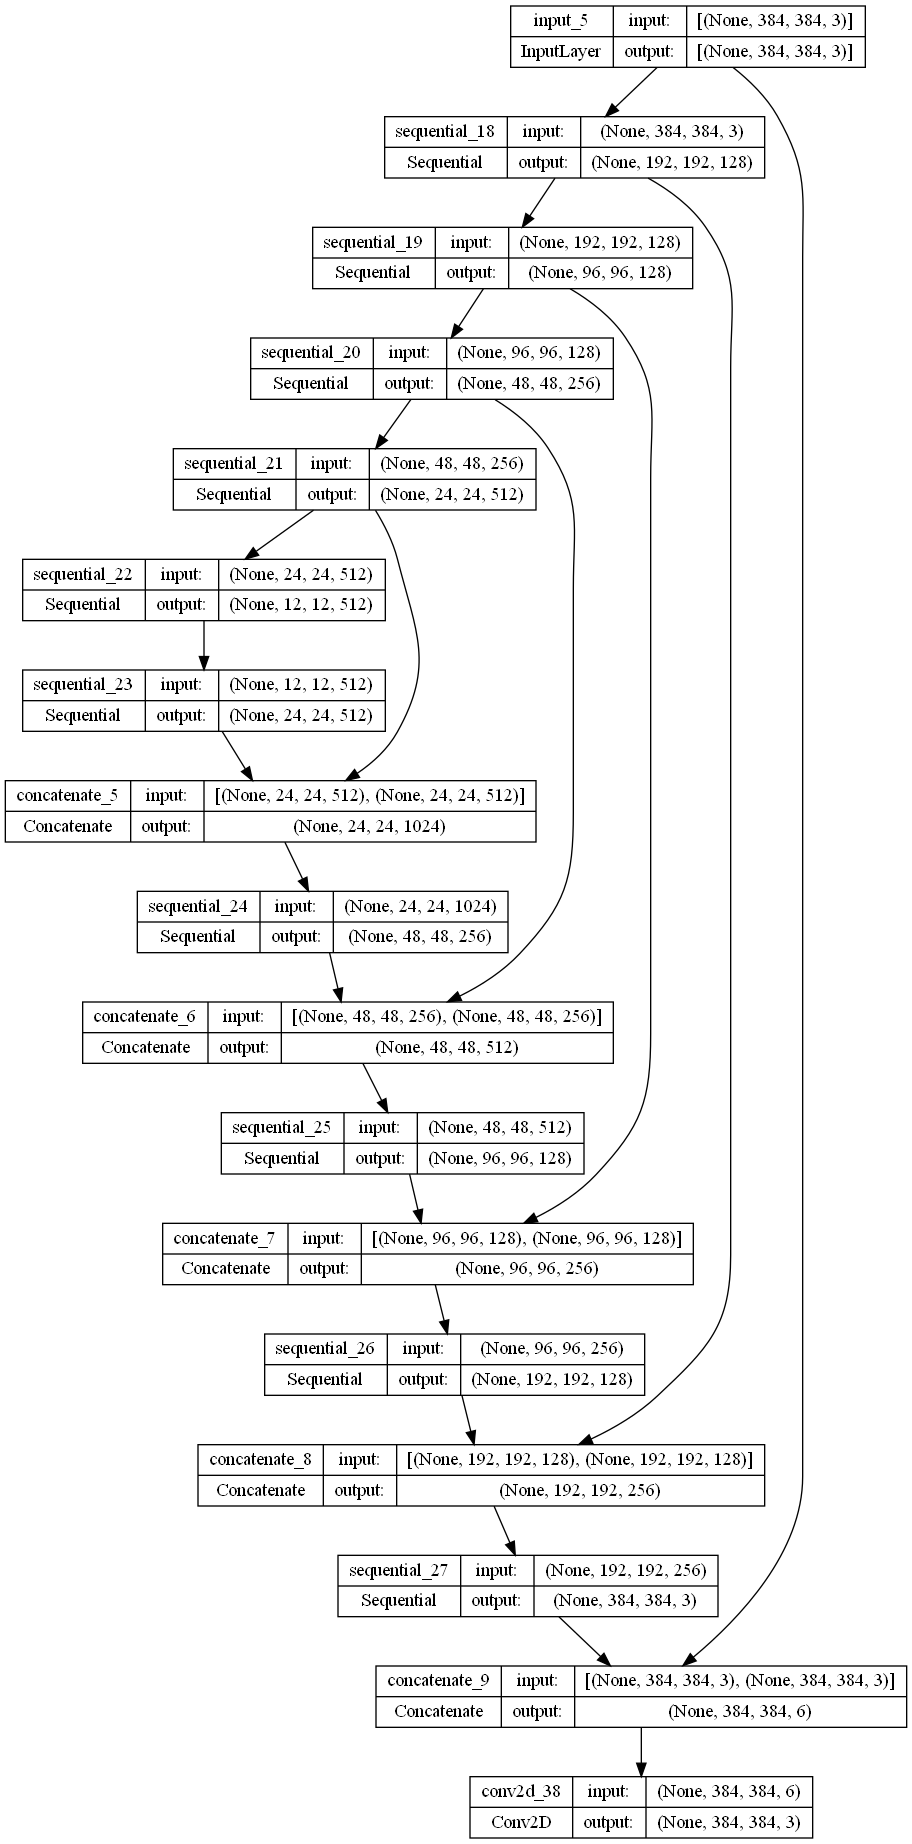

In [128]:
from keras import layers
from keras.utils import plot_model
from keras.layers import LeakyReLU

def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [384,384,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)

    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return Model(inputs=inputs, outputs=output)

model = model()
model.summary()
plot_model(model, to_file ='super_res.png',show_shapes=True)

In [129]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [130]:
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
3/3 [==============================] - 27s 9s/step - loss: 0.2175 - acc: 0.3688
Epoch 2/3
3/3 [==============================] - 26s 8s/step - loss: 0.1691 - acc: 0.3543
Epoch 3/3
3/3 [==============================] - 27s 9s/step - loss: 0.1479 - acc: 0.4282


In [121]:
pre = model.predict(x_test)

1/1 [==============================] - 1s 958ms/step


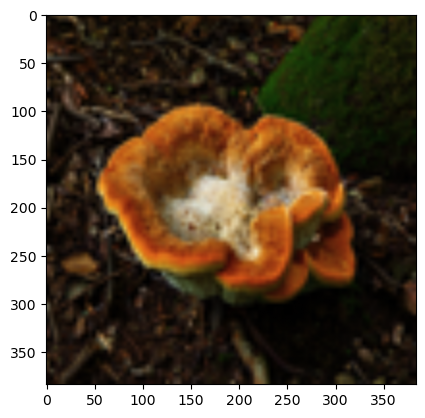

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


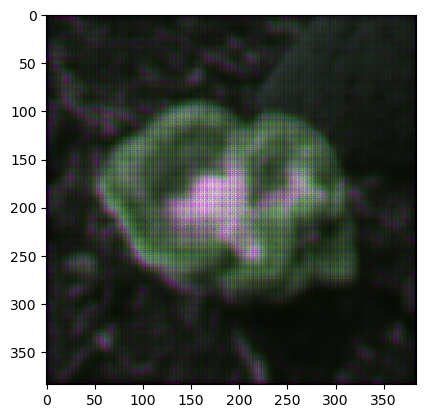

In [122]:
plt.imshow(x_test[1])
plt.show()

plt.imshow(pre[1])
plt.show()

In [100]:
pre[10]

IndexError: index 10 is out of bounds for axis 0 with size 10